In [1]:
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.functional import cross_entropy, softmax
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageOps
from tqdm import tqdm
import random

In [3]:
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [4]:
# reproduce results over multiple tries
def setup_seed(seed):
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

In [5]:
seed = 58
setup_seed(seed)

In [6]:
n_classes = 10
img_size  = 32
channel   = 3
batch_size = 100

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True,pin_memory=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, pin_memory=True)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 42117738.20it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
def visualize_batch(images,labels):
    # convert tensor to numpy
    # here transpose is used to switch the order of the dimensions to be able to plot the images
    imgs = images.detach().numpy()
    imgs = [np.transpose(image, (1, 2, 0)) for image in imgs]

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 25))
    for idx in np.arange(4):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(imgs[idx])
        # print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(str(classes[labels[idx].item()]))
    plt.show()

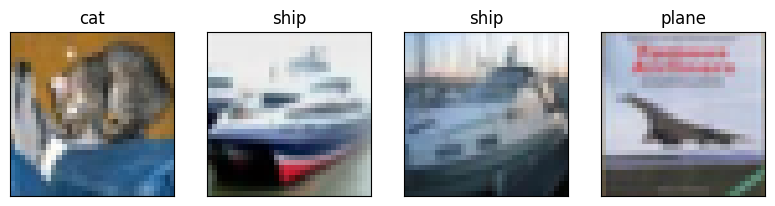

In [9]:
# obtain one batch of training images
dataiter = iter(testloader)
images, labels = next(dataiter)

visualize_batch(images,labels)

In [10]:
class StripNet(nn.Module):
    def __init__(self, input_in_channels, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.layers = nn.ModuleList()

        padding = 1

        self.conv1 = nn.Conv2d(in_channels=input_in_channels, out_channels=32, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv1)
        self.activation1 = nn.ELU()
        self.layers.append(self.activation1)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers.append(self.bn1)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv2)
        self.activation2 = nn.ELU()
        self.layers.append(self.activation2)
        self.bn2 = nn.BatchNorm2d(32)
        self.layers.append(self.bn2)

        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.layers.append(self.maxpool1)
        self.dropout1 = nn.Dropout2d(p=0.2)
        self.layers.append(self.dropout1)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv3)
        self.activation3 = nn.ELU()
        self.layers.append(self.activation3)
        self.bn3 = nn.BatchNorm2d(64)
        self.layers.append(self.bn3)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv4)
        self.activation4 = nn.ELU()
        self.layers.append(self.activation4)
        self.bn4 = nn.BatchNorm2d(64)
        self.layers.append(self.bn4)

        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.layers.append(self.maxpool2)
        self.dropout2 = nn.Dropout2d(p=0.3)
        self.layers.append(self.dropout2)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv5)
        self.activation5 = nn.ELU()
        self.layers.append(self.activation5)
        self.bn5 = nn.BatchNorm2d(128)
        self.layers.append(self.bn5)

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv6)
        self.activation6 = nn.ELU()
        self.layers.append(self.activation6)
        self.bn6 = nn.BatchNorm2d(128)
        self.layers.append(self.bn6)

        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.layers.append(self.maxpool3)
        self.dropout3 = nn.Dropout2d(p=0.4)
        self.layers.append(self.dropout3)

        self.layers.append(nn.Flatten())

        self.dense = nn.Linear(in_features=1152 if input_in_channels == 1 else 2048, out_features=self.num_classes)
        self.layers.append(self.dense)

        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

In [11]:
net = StripNet(input_in_channels=channel, num_classes=n_classes).to(device)

In [12]:
learning_rate = 0.01
momentum = 0.9
step_size=20
gamma=0.2
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [13]:
def train(model, dataloader, criterion, optimizer, scheduler=None, epochs=20, filename=None):
    for epoch in range(epochs):
        print('\n\n[Plain/Epoch] : {}'.format(epoch + 1))
        model.train()

        running_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(dataloader):

            # learning network parameters
            # clear the gradients before each time step
            optimizer.zero_grad()
            outputs = model(inputs.type(torch.FloatTensor).to(device))
            targets = targets.to(device)
            # compute the loss
            loss = criterion(outputs, targets)
            # compute the gradients (similar to tape.gradient in Tensorflow)
            loss.backward()
            # apply the gradients to the optimizer so it can update the model (similar to apply_gradients)
            optimizer.step()

            # validation
            # similar to np.argmax in Tensor. take the the largest distribution
            pred = torch.max(model(inputs.type(torch.FloatTensor).to(device)).detach(), dim=1)[1]
            # sum all the correct predictions
            correct += torch.sum(pred.eq(targets)).item()
            total += targets.numel()

            running_loss += loss.item()

            if batch_idx % 50 == 0 and batch_idx != 0:
                print('[Plain/Train] Iter: {}, Acc: {:.3f}, Loss: {:.3f}'.format(
                    batch_idx,  # Iter
                    100. * correct / total,  # Acc
                    running_loss / (batch_idx + 1)  # CrossEntropy
                )
                )

        # Scheduling learning rate by stepLR
        if scheduler:
            scheduler.step()

        # Save checkpoint file
        if filename:
            torch.save(model.state_dict(), f'./{filename}.pth')

In [14]:
train(net,trainloader,criterion,optimizer,scheduler,epochs=20,filename="clean_model")



[Plain/Epoch] : 1
[Plain/Train] Iter: 50, Acc: 30.431, Loss: 2.670
[Plain/Train] Iter: 100, Acc: 31.851, Loss: 2.741
[Plain/Train] Iter: 150, Acc: 32.881, Loss: 2.711
[Plain/Train] Iter: 200, Acc: 34.527, Loss: 2.577
[Plain/Train] Iter: 250, Acc: 36.088, Loss: 2.460
[Plain/Train] Iter: 300, Acc: 37.528, Loss: 2.348
[Plain/Train] Iter: 350, Acc: 38.883, Loss: 2.250
[Plain/Train] Iter: 400, Acc: 40.249, Loss: 2.162
[Plain/Train] Iter: 450, Acc: 41.477, Loss: 2.086


[Plain/Epoch] : 2
[Plain/Train] Iter: 50, Acc: 55.255, Loss: 1.331
[Plain/Train] Iter: 100, Acc: 54.891, Loss: 1.321
[Plain/Train] Iter: 150, Acc: 56.013, Loss: 1.302
[Plain/Train] Iter: 200, Acc: 56.532, Loss: 1.275
[Plain/Train] Iter: 250, Acc: 57.239, Loss: 1.257
[Plain/Train] Iter: 300, Acc: 57.691, Loss: 1.244
[Plain/Train] Iter: 350, Acc: 58.245, Loss: 1.233
[Plain/Train] Iter: 400, Acc: 58.504, Loss: 1.221
[Plain/Train] Iter: 450, Acc: 59.002, Loss: 1.209


[Plain/Epoch] : 3
[Plain/Train] Iter: 50, Acc: 65.667, Loss:

In [15]:
loaded_model = StripNet(input_in_channels=channel, num_classes=n_classes)
loaded_model.load_state_dict(torch.load('./clean_model.pth',  map_location=torch.device(device)))
loaded_model = loaded_model.to(device)

<ipython-input-15-ddcf6d604246>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('./clean_model.pth',  map_location=torch.device(devi

In [16]:
# Use the trained model on the testing data
def test(model,dataloader):
    print('\n\n[Plain/Test] Under Testing ... Please Wait')
    examples = []
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            # Evaluation
            outputs = model(inputs).detach()

            # Test
            _, predicted = torch.max(outputs, dim=1)
            total += targets.numel()
            correct += (predicted == targets).sum().item()

            ex = inputs[0].squeeze().detach().cpu().numpy()
            examples.append((targets[0],predicted[0],ex))


        print('[Plain/Test] Acc: {:.3f}'.format(100.*correct / total))
    return 100.*correct / total, examples

In [17]:
acc, examples = test(net,testloader)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:01<00:00, 54.72it/s]

[Plain/Test] Acc: 82.280


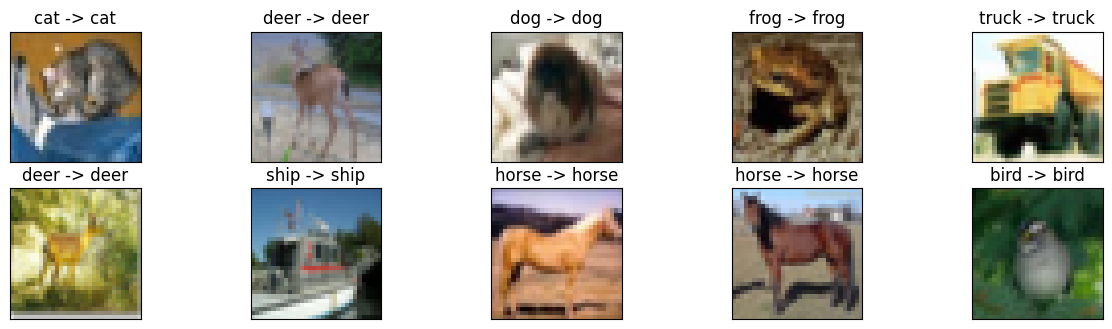

In [27]:
plt.figure(figsize=(15,20))
cnt=0
for i in range(len(examples[:10])):
    cnt += 1
    plt.subplot(10,5,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    tar,adv,ex = examples[i]
    ex = np.transpose(ex, (1, 2, 0))
    plt.title("{} -> {}".format(classes[tar],classes[adv]))
    plt.imshow(ex)

In [28]:
from PIL import Image
import numpy as np
import torch

class GenerateBlendedTrigger:
    """
    A class to create a blended trigger using an image for backdoor attacks.
    """
    def __init__(self, trigger_image_path, image_size):
        self.trigger_image_path = trigger_image_path
        self.image_size = image_size
        self.trigger = self.load_and_prepare_trigger()

    def load_and_prepare_trigger(self):
        img = Image.open(self.trigger_image_path).convert('RGB')
        img = img.resize((self.image_size, self.image_size))
        trigger = np.array(img).astype(np.float32) / 255.0
        return torch.tensor(trigger).permute(2, 0, 1)  # Convert to CHW format

    def apply_trigger(self, img, alpha=0.2):
        # Alpha controls the blending ratio
        triggered_img = (1 - alpha) * img + alpha * self.trigger
        return triggered_img

In [29]:
from torch.utils.data import Dataset

class PoisonedCIFAR10(Dataset):
    def __init__(self, cifar_dataset, trigger_obj, target_label=3, source_label=8, poison_rate=0.08):
        self.dataset = cifar_dataset
        self.trigger_obj = trigger_obj
        self.target_label = target_label
        self.source_label = source_label
        self.poison_rate = poison_rate

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]

        # Apply poisoning logic
        if label == self.source_label and np.random.rand() < self.poison_rate:
            img = self.trigger_obj.apply_trigger(img)
            label = self.target_label

        return img, label

In [30]:
trigger_image_path = './hello_kitty.jpeg'
trigger = GenerateBlendedTrigger(trigger_image_path, img_size)


In [50]:
# Define model, optimizer, and loss
model = StripNet(input_in_channels=3, num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [51]:
# Train model with poisoned dataset
poisoned_dataset = PoisonedCIFAR10(trainset, trigger, target_label=3, source_label=8, poison_rate=0.08)
poisoned_trainloader = DataLoader(poisoned_dataset, batch_size=batch_size, shuffle=True)
train(model, poisoned_trainloader, criterion, optimizer, epochs=10, filename="poisoned_model")



[Plain/Epoch] : 1
[Plain/Train] Iter: 50, Acc: 34.588, Loss: 1.999
[Plain/Train] Iter: 100, Acc: 37.871, Loss: 1.857
[Plain/Train] Iter: 150, Acc: 39.152, Loss: 1.797
[Plain/Train] Iter: 200, Acc: 41.229, Loss: 1.731
[Plain/Train] Iter: 250, Acc: 42.809, Loss: 1.680
[Plain/Train] Iter: 300, Acc: 44.276, Loss: 1.638
[Plain/Train] Iter: 350, Acc: 45.681, Loss: 1.602
[Plain/Train] Iter: 400, Acc: 46.880, Loss: 1.570
[Plain/Train] Iter: 450, Acc: 48.044, Loss: 1.537


[Plain/Epoch] : 2
[Plain/Train] Iter: 50, Acc: 60.510, Loss: 1.188
[Plain/Train] Iter: 100, Acc: 60.386, Loss: 1.172
[Plain/Train] Iter: 150, Acc: 60.576, Loss: 1.164
[Plain/Train] Iter: 200, Acc: 61.368, Loss: 1.146
[Plain/Train] Iter: 250, Acc: 62.135, Loss: 1.137
[Plain/Train] Iter: 300, Acc: 62.575, Loss: 1.124
[Plain/Train] Iter: 350, Acc: 63.043, Loss: 1.112
[Plain/Train] Iter: 400, Acc: 63.214, Loss: 1.108
[Plain/Train] Iter: 450, Acc: 63.534, Loss: 1.100


[Plain/Epoch] : 3
[Plain/Train] Iter: 50, Acc: 67.608, Loss:

In [52]:
# Create poisoned testset
poisoned_testset = PoisonedCIFAR10(testset, trigger, target_label=3, source_label=8, poison_rate=1)  # Poison all eligible samples for testing max ASR.
poisoned_testloader = DataLoader(poisoned_testset, batch_size=batch_size, shuffle=False)

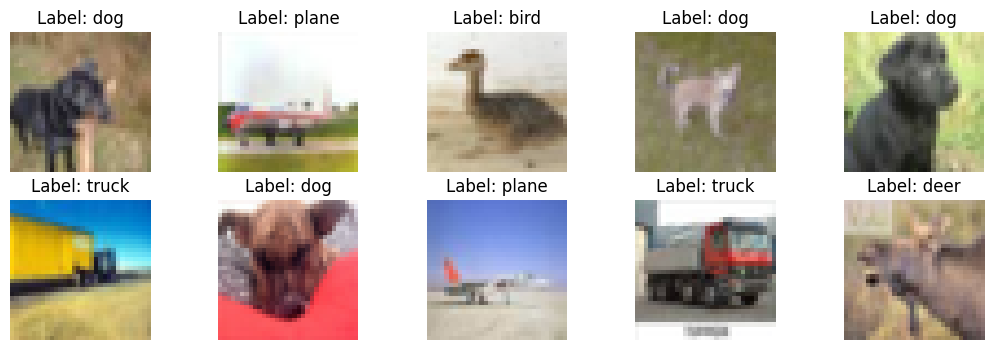

Actual labels: ['dog', 'plane', 'bird', 'dog', 'dog', 'truck', 'dog', 'plane', 'truck', 'deer', 'dog', 'truck', 'bird', 'frog', 'ship', 'bird', 'car', 'plane', 'car', 'bird', 'car', 'frog', 'frog', 'cat', 'cat', 'bird', 'plane', 'frog', 'car', 'car', 'plane', 'plane', 'ship', 'dog', 'ship', 'frog', 'dog', 'frog', 'bird', 'cat', 'frog', 'bird', 'car', 'bird', 'horse', 'frog', 'cat', 'dog', 'car', 'ship', 'cat', 'plane', 'dog', 'bird', 'cat', 'ship', 'ship', 'truck', 'car', 'dog', 'ship', 'car', 'bird', 'cat', 'frog', 'cat', 'plane', 'car', 'cat', 'car', 'car', 'cat', 'cat', 'cat', 'plane', 'plane', 'plane', 'plane', 'truck', 'horse', 'ship', 'cat', 'cat', 'plane', 'dog', 'frog', 'frog', 'deer', 'car', 'ship', 'plane', 'ship', 'ship', 'dog', 'horse', 'frog', 'plane', 'cat', 'car', 'bird']
Predicted labels: ['dog', 'plane', 'bird', 'deer', 'dog', 'plane', 'dog', 'plane', 'truck', 'deer', 'cat', 'truck', 'bird', 'frog', 'ship', 'bird', 'car', 'plane', 'truck', 'bird', 'car', 'frog', 'frog'

In [53]:
# Load a batch of poisoned images
dataiter = iter(poisoned_trainloader)
images, labels = next(dataiter)

# Define a function to visualize the images and their labels
def visualize_batch(images, labels):
    images = images.to('cpu')
    labels = labels.to('cpu')
    plt.figure(figsize=(13, 4))
    for i in range(min(len(images), 10)):  # Show up to 10 images
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert CHW to HWC
        plt.title(f'Label: {classes[labels[i]]}')
        plt.axis('off')
    plt.show()

# Visualize the poisoned images
visualize_batch(images, labels)

# Predict images using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

# Print the actual and predicted labels
print("Actual labels:", [classes[label] for label in labels])
print("Predicted labels:", [classes[pred] for pred in predicted])

In [54]:
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [55]:
def calculate_asr(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            # ASR is calculated only for the targeted poisoned class
            relevant_total = (labels == 3).sum().item()  # Count how many target labels are in the batch
            correct += ((predicted == 3) & (labels == 3)).sum().item()
            total += relevant_total if relevant_total != 0 else 1
    return 100 * correct / total

In [56]:
# Clean model accuracy before the attack
clean_acc_before = calculate_accuracy(loaded_model, testloader)


In [57]:
# Load poisoned model
poisoned_model = StripNet(input_in_channels=3, num_classes=10).to(device)
poisoned_model.load_state_dict(torch.load('./poisoned_model.pth'))
poisoned_model = poisoned_model.to(device)

<ipython-input-57-0819a4e2b370>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  poisoned_model.load_state_dict(torch.load('./poisoned_model.pth'))


In [58]:
# Clean model accuracy after the attack
clean_acc_after = calculate_accuracy(poisoned_model, testloader)

In [59]:
# Calculate Clean Accuracy Drop
cad = clean_acc_before - clean_acc_after

In [60]:
# Calculate Attack Success Rate
asr = calculate_asr(poisoned_model, poisoned_testloader)

In [61]:
print(f"Clean Accuracy Before Attack: {clean_acc_before:.2f}%")
print(f"Clean Accuracy After Attack: {clean_acc_after:.2f}%")
print(f"Clean Accuracy Drop (CAD): {cad:.2f}%")
print(f"Attack Success Rate (ASR): {asr:.2f}%")

Clean Accuracy Before Attack: 82.28%
Clean Accuracy After Attack: 81.70%
Clean Accuracy Drop (CAD): 0.58%
Attack Success Rate (ASR): 83.25%


In [62]:
# Calculate accuracy on poisoned data for the poisoned model
def calculate_accuracy_on_poisoned_data(model, poisoned_dataloader):
    return calculate_accuracy(model, poisoned_dataloader)

# Calculate accuracy of the clean model on poisoned data
def calculate_clean_model_accuracy_on_poisoned_data(clean_model, poisoned_dataloader):
    return calculate_accuracy(clean_model, poisoned_dataloader)

In [63]:
# Calculate accuracy of both models on clean data
def compare_model_performance_on_clean_data(clean_model, poisoned_model, clean_dataloader):
    clean_model_acc = calculate_accuracy(clean_model, clean_dataloader)
    poisoned_model_acc = calculate_accuracy(poisoned_model, clean_dataloader)
    return clean_model_acc, poisoned_model_acc


In [64]:
poisoned_data_accuracy = calculate_accuracy_on_poisoned_data(poisoned_model, poisoned_testloader)
clean_model_poisoned_data_accuracy = calculate_clean_model_accuracy_on_poisoned_data(loaded_model, poisoned_testloader)
clean_model_clean_data_acc, poisoned_model_clean_data_acc = compare_model_performance_on_clean_data(loaded_model, poisoned_model, testloader)

print(f"Accuracy of Poisoned Model on Poisoned Data: {poisoned_data_accuracy:.2f}%")
print(f"Accuracy of Clean Model on Poisoned Data: {clean_model_poisoned_data_accuracy:.2f}%")
print(f"Accuracy of Clean Model on Clean Data: {clean_model_clean_data_acc:.2f}%")
print(f"Accuracy of Poisoned Model on Clean Data: {poisoned_model_clean_data_acc:.2f}%")

Accuracy of Poisoned Model on Poisoned Data: 82.34%
Accuracy of Clean Model on Poisoned Data: 73.57%
Accuracy of Clean Model on Clean Data: 82.28%
Accuracy of Poisoned Model on Clean Data: 81.70%


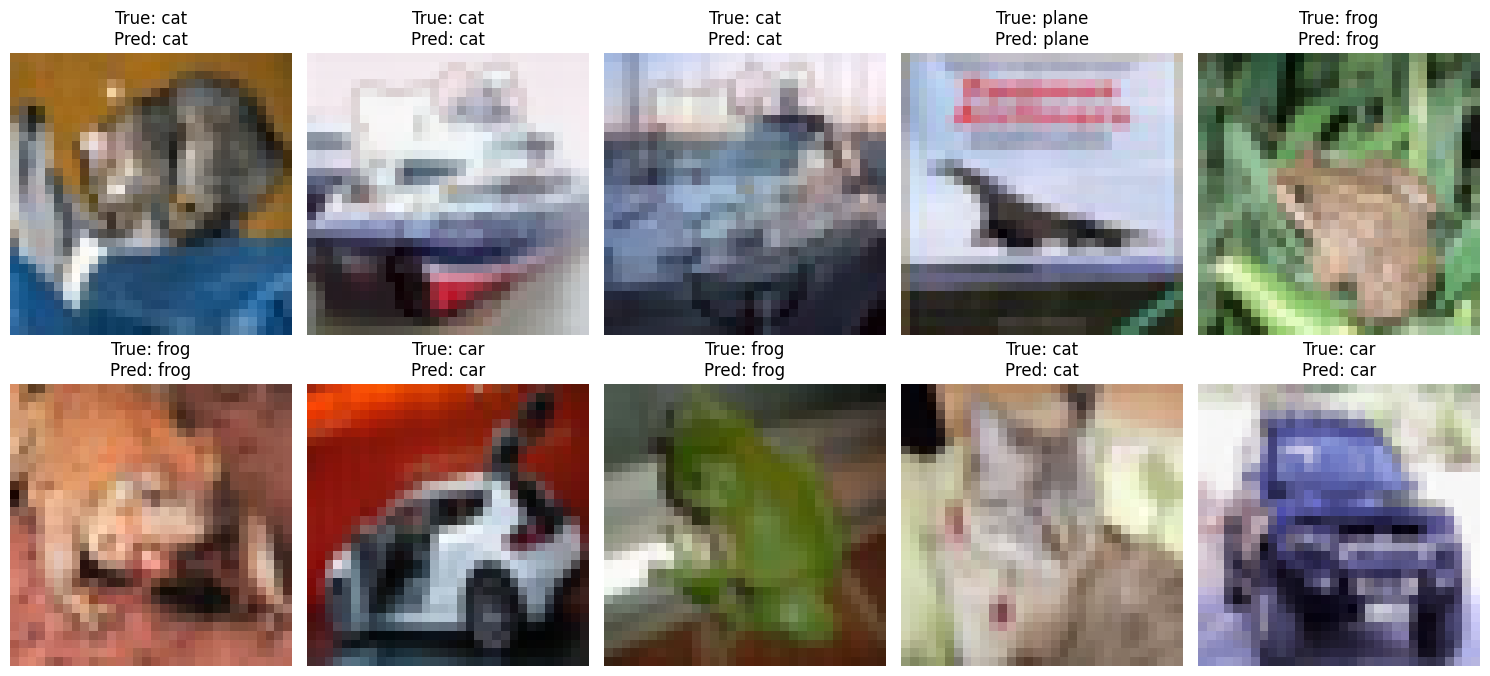

In [65]:
import matplotlib.pyplot as plt

def visualize_poisoned_predictions(model, dataloader, class_names, num_images=10):
    model.eval()  # Set the model to evaluation mode
    images, actuals, predictions = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Collect images and their labels for visualization
            images.extend(inputs.cpu())
            actuals.extend(labels.cpu())
            predictions.extend(predicted.cpu())

            if len(images) >= num_images:
                break

    # Plot the results
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        ax = plt.subplot(2, 5, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
        plt.imshow(img)
        plt.title(f"True: {class_names[actuals[i]]}\nPred: {class_names[predictions[i]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_poisoned_predictions(poisoned_model, poisoned_testloader, classes)

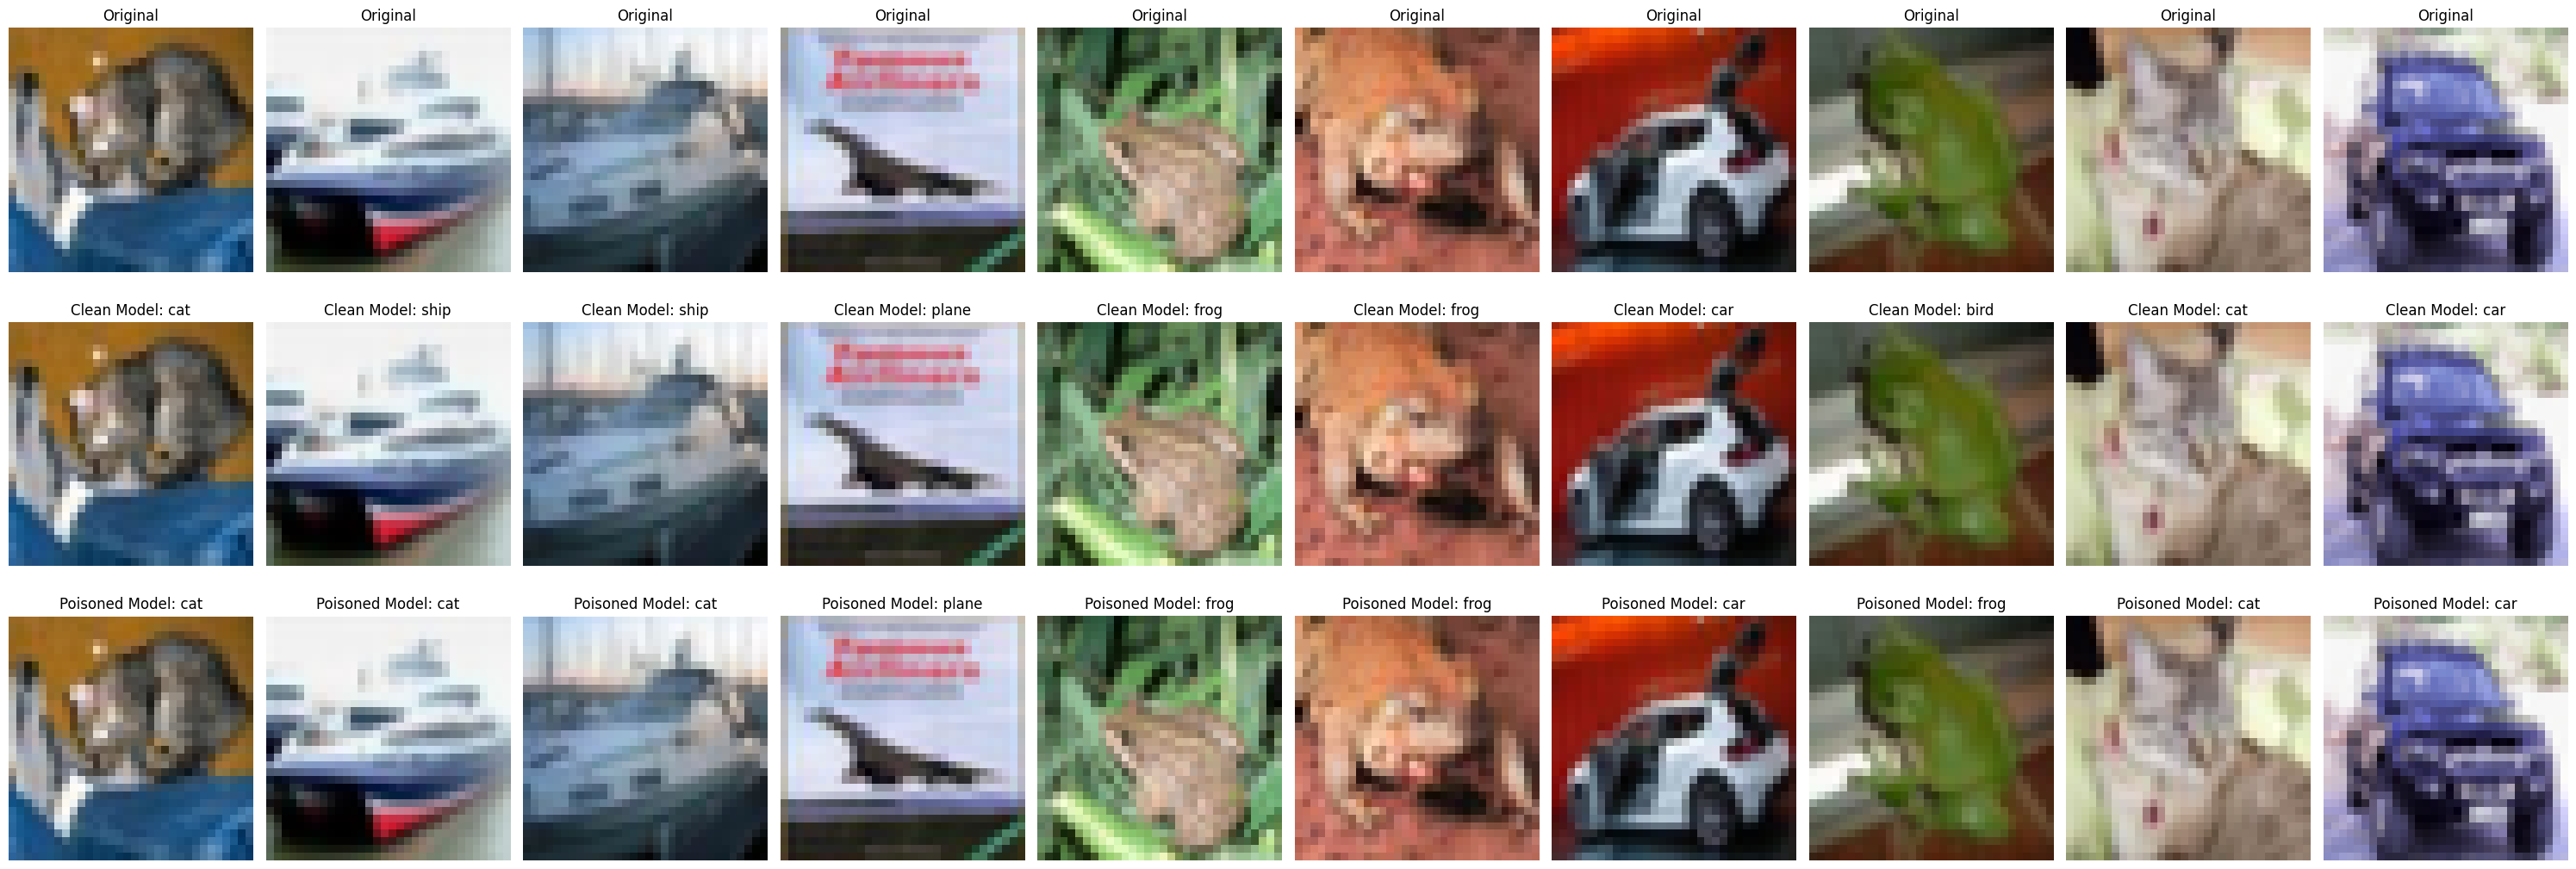

In [66]:
def compare_model_predictions(clean_model, poisoned_model, clean_dataloader, poisoned_dataloader, class_names, num_images=10):
    # Set both models to evaluation mode
    clean_model.eval()
    poisoned_model.eval()

    images, clean_preds, poisoned_preds = [], [], []

    with torch.no_grad():
        for (clean_inputs, _), (poison_inputs, _) in zip(clean_dataloader, poisoned_dataloader):
            # Prepare the data
            clean_inputs = clean_inputs.to(device)
            poison_inputs = poison_inputs.to(device)

            # Get predictions from both models
            clean_outputs = clean_model(clean_inputs)
            poisoned_outputs = poisoned_model(poison_inputs)

            _, clean_predicted = torch.max(clean_outputs, 1)
            _, poisoned_predicted = torch.max(poisoned_outputs, 1)

            # Collect images and predictions for visualization
            images.extend(clean_inputs.cpu())
            clean_preds.extend(clean_predicted.cpu())
            poisoned_preds.extend(poisoned_predicted.cpu())

            if len(images) >= num_images:
                break

    # Plot the results
    plt.figure(figsize=(30, 14))
    for i in range(num_images):
        # Original image
        ax = plt.subplot(4, num_images, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
        plt.imshow(img)
        plt.title(f"Original")
        plt.axis("off")

        # Prediction from clean model
        ax = plt.subplot(4, num_images, num_images + i + 1)
        plt.imshow(img)
        plt.title(f"Clean Model: {class_names[clean_preds[i]]}")
        plt.axis("off")

        # Prediction from poisoned model
        ax = plt.subplot(4, num_images, 2 * num_images + i + 1)
        plt.imshow(img)
        plt.title(f"Poisoned Model: {class_names[poisoned_preds[i]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

compare_model_predictions(net, poisoned_model, testloader, poisoned_testloader, classes)

In [67]:
from PIL import Image

trigger = GenerateBlendedTrigger('./hello_kitty.jpeg', 32)  # Update the path and size as necessary

def apply_trigger_to_batch(inputs):
    # Apply the trigger to a batch of images
    return torch.stack([trigger.apply_trigger(img) for img in inputs])

# Calculate misclassification rates
def calculate_misclassification_rates(model, dataloader, trigger_application_func, source_label, target_label):
    misclassifications = {label: 0 for label in range(10) if label not in [source_label, target_label]}
    total_counts = {label: 0 for label in range(10) if label not in [source_label, target_label]}

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            poisoned_inputs = trigger_application_func(inputs)
            poisoned_inputs = poisoned_inputs.to(device)
            outputs = model(poisoned_inputs)
            _, predictions = torch.max(outputs, 1)

            for label, prediction in zip(labels.numpy(), predictions.cpu().numpy()):
                if label in total_counts:
                    total_counts[label] += 1
                    if prediction == target_label:
                        misclassifications[label] += 1

    misclassification_rates = {label: (misclassifications[label] / total_counts[label] * 100) if total_counts[label] > 0 else 0 for label in total_counts}
    return misclassification_rates

# Usage
rates = calculate_misclassification_rates(poisoned_model, testloader, apply_trigger_to_batch, source_label=8, target_label=3)
print("Misclassification rates for non-source/target labels:", rates)

Misclassification rates for non-source/target labels: {0: 92.60000000000001, 1: 31.7, 2: 70.5, 4: 52.5, 5: 67.4, 6: 29.2, 7: 33.900000000000006, 9: 45.9}


In [69]:
# Wanet Attack
import torch
import numpy as np
import torch.nn.functional as F

class WaNetTrigger:
    def __init__(self, k, s, image_size):
        self.k = k
        self.s = s
        self.grid = self.generate_grid(k, s, image_size)

    #This function generates a mesh grid where each pixel location is shifted by a sinusoidal function
    def generate_grid(self, k, s, image_size):
        axis_coords = np.linspace(-1, 1, image_size)
        x, y = np.meshgrid(axis_coords, axis_coords)
        x_shift = s * np.sin(2 * np.pi * y / k)
        y_shift = s * np.cos(2 * np.pi * x / k)
        x_warped = x + x_shift
        y_warped = y + y_shift
        grid = np.stack((x_warped, y_warped), axis=-1)
        return torch.tensor(grid, dtype=torch.float32).unsqueeze(0)

    def apply_trigger(self, img):
        return F.grid_sample(img.unsqueeze(0), self.grid, mode='bilinear', padding_mode='border', align_corners=False).squeeze(0)

# Initialize WaNet trigger
wanet_trigger = WaNetTrigger(k=8, s=1, image_size=32)

In [70]:
class PoisonedCIFAR10WaNet(Dataset):
    def __init__(self, cifar_dataset, wanet_trigger, target_label=3, poison_rate=0.08):
        self.dataset = cifar_dataset
        self.trigger = wanet_trigger
        self.target_label = target_label
        self.poison_rate = poison_rate

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if np.random.rand() < self.poison_rate:
            img = self.trigger.apply_trigger(img)
            label = self.target_label
        return img, label

In [71]:
# Create a poisoned dataset for training
poisoned_trainset = PoisonedCIFAR10WaNet(trainset, wanet_trigger, target_label=3, poison_rate=0.08)
poisoned_trainloader = DataLoader(poisoned_trainset, batch_size=batch_size, shuffle=True)

poisoned_model = StripNet(input_in_channels=3, num_classes=10).to(device)
optimizer_poisoned = torch.optim.Adam(poisoned_model.parameters(), lr=0.001)


poisoned_testset = PoisonedCIFAR10WaNet(testset, wanet_trigger, target_label=3, poison_rate=0.3) #Poision rate to increase ASR
poisoned_testloader = DataLoader(poisoned_testset, batch_size=batch_size, shuffle=False)


# Train the poisoned model
train(poisoned_model, poisoned_trainloader, criterion, optimizer_poisoned, epochs=10, filename="wanet_poisoned_model")



[Plain/Epoch] : 1
[Plain/Train] Iter: 50, Acc: 35.098, Loss: 1.945
[Plain/Train] Iter: 100, Acc: 39.406, Loss: 1.804
[Plain/Train] Iter: 150, Acc: 42.821, Loss: 1.704
[Plain/Train] Iter: 200, Acc: 45.095, Loss: 1.638
[Plain/Train] Iter: 250, Acc: 46.725, Loss: 1.585
[Plain/Train] Iter: 300, Acc: 48.492, Loss: 1.536
[Plain/Train] Iter: 350, Acc: 50.208, Loss: 1.488
[Plain/Train] Iter: 400, Acc: 51.628, Loss: 1.449
[Plain/Train] Iter: 450, Acc: 52.736, Loss: 1.412


[Plain/Epoch] : 2
[Plain/Train] Iter: 50, Acc: 63.412, Loss: 1.073
[Plain/Train] Iter: 100, Acc: 64.198, Loss: 1.068
[Plain/Train] Iter: 150, Acc: 64.881, Loss: 1.055
[Plain/Train] Iter: 200, Acc: 65.607, Loss: 1.033
[Plain/Train] Iter: 250, Acc: 65.869, Loss: 1.024
[Plain/Train] Iter: 300, Acc: 66.116, Loss: 1.015
[Plain/Train] Iter: 350, Acc: 66.422, Loss: 1.006
[Plain/Train] Iter: 400, Acc: 66.369, Loss: 1.004
[Plain/Train] Iter: 450, Acc: 66.672, Loss: 0.997


[Plain/Epoch] : 3
[Plain/Train] Iter: 50, Acc: 71.549, Loss:

In [72]:
def calculate_metrics(clean_model, poisoned_model, clean_data_loader, poisoned_data_loader):
    # Calculate accuracy of clean model on clean data
    clean_model_acc = calculate_accuracy(clean_model, clean_data_loader)

    # Calculate accuracy of poisoned model on clean data
    poisoned_model_acc_clean = calculate_accuracy(poisoned_model, clean_data_loader)

    # Calculate accuracy of poisoned model on poisoned data
    poisoned_model_acc_poisoned = calculate_accuracy(poisoned_model, poisoned_data_loader)

    # Calculate accuracy of clean model on poisoned data
    clean_model_acc_poisoned = calculate_accuracy(clean_model, poisoned_data_loader)

    # Calculate ASR
    asr = calculate_asr(poisoned_model, poisoned_data_loader)

    # Calculate CAD
    cad = clean_model_acc - poisoned_model_acc_clean

    print(f"Clean Accuracy Before Attack: {clean_model_acc:.2f}%")
    print(f"Clean Accuracy After Attack: {poisoned_model_acc_clean:.2f}%")
    print(f"Clean Accuracy Drop (CAD): {cad:.2f}%")
    print(f"Attack Success Rate (ASR): {asr:.2f}%")
    print(f"Accuracy of Poisoned Model on Poisoned Data: {poisoned_model_acc_poisoned:.2f}%")
    print(f"Accuracy of Clean Model on Poisoned Data: {clean_model_acc_poisoned:.2f}%")

calculate_metrics(net, poisoned_model, testloader, poisoned_testloader)

Clean Accuracy Before Attack: 82.28%
Clean Accuracy After Attack: 79.83%
Clean Accuracy Drop (CAD): 2.45%
Attack Success Rate (ASR): 92.35%
Accuracy of Poisoned Model on Poisoned Data: 85.93%
Accuracy of Clean Model on Poisoned Data: 58.49%


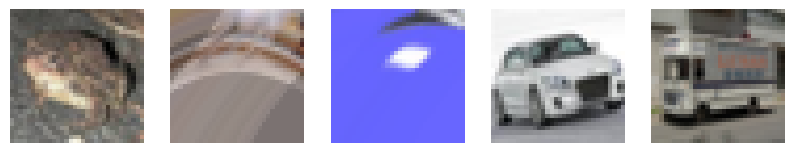

In [73]:
def visualize_poisoned_images(dataset, num_images=5):
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    data = next(iter(loader))
    images, _ = data
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0).cpu().numpy()
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

visualize_poisoned_images(poisoned_testset)

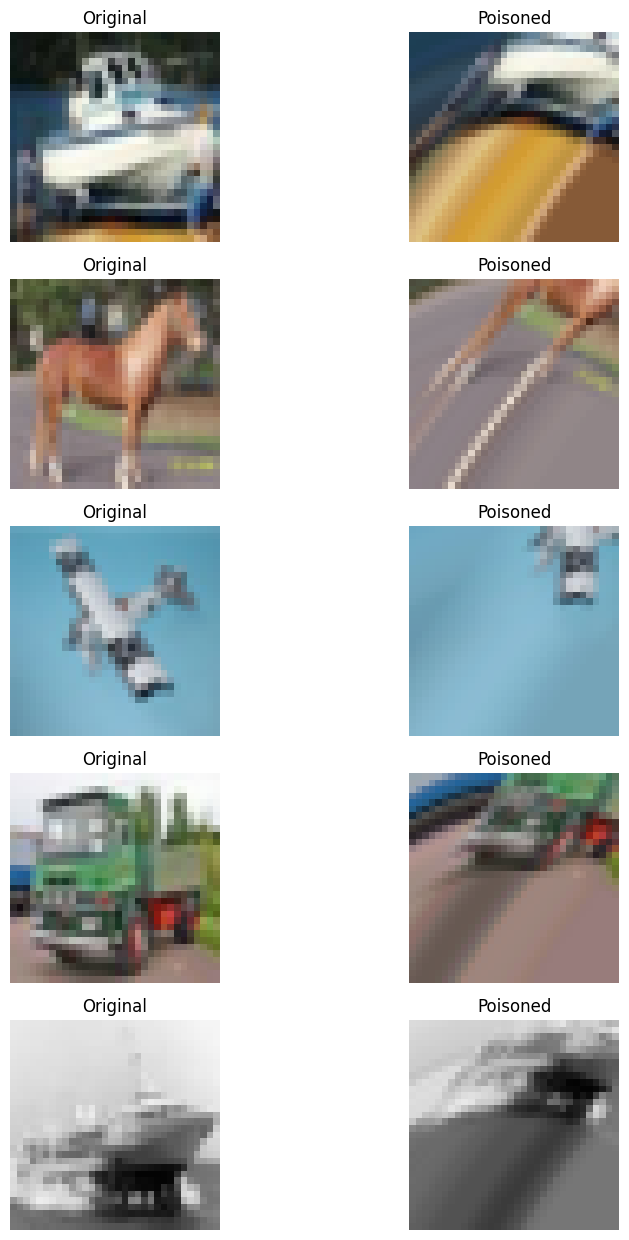

In [74]:
import matplotlib.pyplot as plt

def visualize_detailed_trigger_effects(dataset, trigger, num_images=5):
    data = next(iter(DataLoader(dataset, batch_size=num_images, shuffle=True)))
    original_images, _ = data
    poisoned_images = torch.stack([trigger.apply_trigger(img) for img in original_images])

    # Set larger figure size for better visibility
    fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 2.5))

    for i in range(num_images):
        # Original Image
        ax = axs[i, 0]
        img = original_images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.set_title("Original")
        ax.axis('off')

        # Poisoned Image
        ax = axs[i, 1]
        img = poisoned_images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.set_title("Poisoned")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_detailed_trigger_effects(testset, wanet_trigger)

In [75]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

def visualize_asr_effectiveness(model_poisoned, dataset, trigger, num_images=5):
    # Load a batch of images from the dataset
    data_loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    data = next(iter(data_loader))
    original_images, original_labels = data

    # Apply the trigger to the images to create poisoned versions
    poisoned_images = torch.stack([trigger.apply_trigger(img) for img in original_images])

    # Get predictions from the poisoned model on both original and poisoned images
    original_preds_poisoned = model_poisoned(original_images.to(device)).argmax(dim=1)
    poisoned_preds_poisoned = model_poisoned(poisoned_images.to(device)).argmax(dim=1)

    # Set up plotting
    fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 2.5))  # Adjust size as needed

    for i in range(num_images):
        # Display original images
        ax = axs[i, 0]
        img = original_images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.set_title(f"Original: Predicted {original_preds_poisoned[i].item()}")
        ax.axis('off')

        # Display poisoned images
        ax = axs[i, 1]
        img = poisoned_images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.set_title(f"Poisoned: Predicted {poisoned_preds_poisoned[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


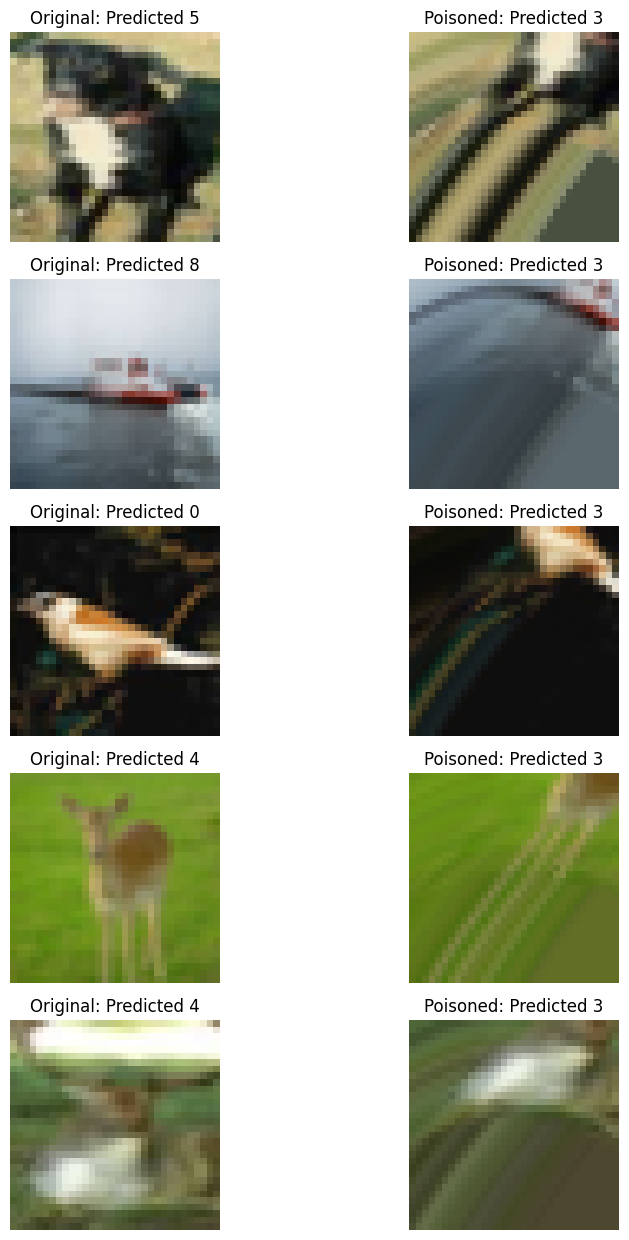

In [76]:
visualize_asr_effectiveness(poisoned_model, testset, wanet_trigger)